In [1]:
import pypsa, os
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pandas as pd

import warnings
from shapely.errors import ShapelyDeprecationWarning

warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)
plt.rc("figure", figsize=(10, 8))
import matplotlib as mpl
to_rgba = mpl.colors.colorConverter.to_rgba

In [2]:
from vresutils import Dict
from snakemake.rules import expand
import yaml
snakemake = Dict()
snakemake.wildcards = Dict(#cost=#'IRP2016-Apr2016',
                            costs='original',
                            regions='27-supply',
                            resarea='redz',
                            ll='copt',
                            opts='LC',
                            attr='p_nom')

snakemake.input = Dict(network='../results/version-0.6/networks/{costs}_{regions}_{resarea}_l{ll}_{opts}.nc'.format(**snakemake.wildcards),
                        supply_regions='../data/supply_regions/supply_regions_{regions}.shp'.format(**snakemake.wildcards),
                        resarea = "../data/bundle/REDZ_DEA_Unpublished_Draft_2015")
snakemake.output = (expand('../results/plots/{costs}_{regions}_{resarea}_l{ll}_{opts}_{attr}.pdf',
                            **snakemake.wildcards) +
                    expand('../results/plots/{costs}_{regions}_{resarea}_l{ll}_{opts}_{attr}_ext.pdf',
                            **snakemake.wildcards))
snakemake.params = Dict(ext=['png'])
# with open('../config.yaml') as f:
#     snakemake.config = yaml.load(f)


import yaml
with open("../config.yaml", 'r') as stream:
    try:
        snakemake.config=yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

tech_costs = "../data/costs.xlsx"

In [3]:
n=pypsa.Network(snakemake.input.network)

INFO:pypsa.io:Imported network original_27-supply_redz_lcopt_LC.nc has buses, carriers, generators, lines, loads, storage_units


In [4]:
opts = snakemake.config['plotting']
line_colors = {'cur': "purple",
               'exp': to_rgba("red", 0.7)}
tech_colors = opts['tech_colors']

In [5]:
n.generators[['bus','carrier','p_nom_opt']].groupby(["bus","carrier"]).sum()

p_nom_opt
bus           carrier                
BLOEMFONTEIN  load     1000000.000000
              onwind      9079.897193
              solar          0.001070
CARLETONVILLE load     1000000.000000
              onwind      1474.352852
...                               ...
WELKOM        solar       3852.532195
WEST COAST    CCGT         796.187516
              OCGT        2334.336311
              load     1000000.000000
WESTRAND      load     1000000.000000

[64 rows x 1 columns]

In [6]:
bus_sizes = pd.concat(
    (
        n.generators.query('carrier != "load"')
        .groupby(["bus", "carrier"])
        .p_nom_opt.sum(),
        n.storage_units.groupby(["bus", "carrier"]).p_nom_opt.sum(),
    )
)
line_widths_exp = n.lines.s_nom_opt
line_widths_cur = n.lines.s_nom_min
link_widths_exp = n.links.p_nom_opt
link_widths_cur = n.links.p_nom_min

In [7]:
attribute="p_nom"
linewidth_factor = opts["map"][attribute]["linewidth_factor"]
bus_size_factor = opts["map"][attribute]["bus_size_factor"]
flow = pd.Series(10, index=n.branches().index)

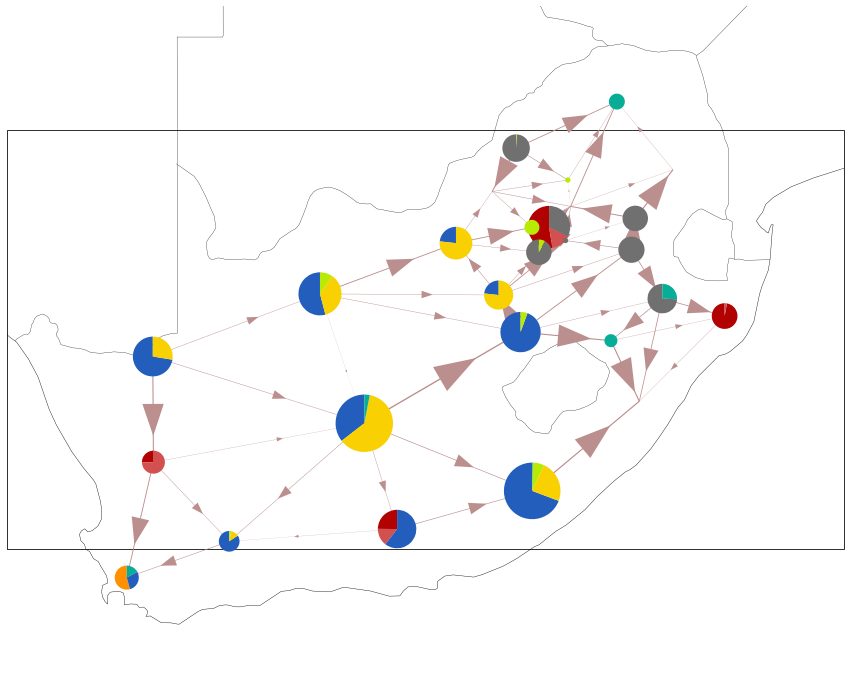

In [8]:
fig, ax = plt.subplots(
    figsize=[15,15], subplot_kw={"projection": ccrs.PlateCarree()}
)

n.plot(
    bus_sizes=bus_sizes / bus_size_factor,
    bus_colors=tech_colors,
    margin=0.2,
    flow="mean",
    line_widths=0.015,
    link_widths=1,
)
plt.show()

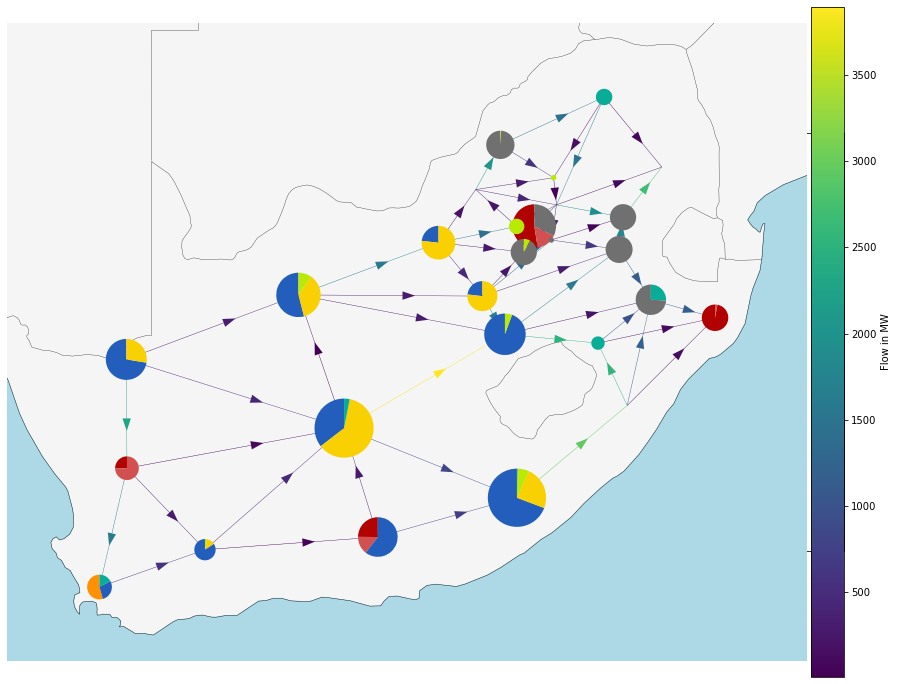

In [9]:
# Pandas series with MultiIndex
# links are not displayed for prettier output ('link_widths=0')
fig, ax = plt.subplots(
    figsize=[15,15], subplot_kw={"projection": ccrs.PlateCarree()}
)

collection = n.plot(
    bus_sizes=bus_sizes / bus_size_factor,
    bus_colors=tech_colors,
    margin=0.15,
    flow=flow,
    line_widths=0.5,
    link_widths=0,
    #projection=ccrs.EqualEarth(),
    color_geomap=True,
    line_colors=n.lines_t.p0.mean().abs(),
)

plt.colorbar(collection[2], fraction=0.04, pad=0.004, label="Flow in MW")
plt.show()

In [10]:
n.generators

,Owner,carrier,p_nom,y,x,efficiency,marginal_cost,capital_cost,ramp_limit_up,bus,...,committable,start_up_cost,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down
Generator,,,,,,,,,,,,,,,,,,,,,
Kendal,Eskom,coal,3840.0,-26.08805,28.96888,0.306305,275.615494,594000.0,0.028125,HIGHVELD NORTH,...,False,0.0,0.0,0,0,1,0,NaN,1.0,1.0
Lethabo,Eskom,coal,3540.0,-26.74027,27.97500,0.328018,179.929392,594000.0,0.100000,VAAL TRIANGLE,...,False,0.0,0.0,0,0,1,0,NaN,1.0,1.0
MajubaDry,Eskom,coal,1830.0,-27.09555,29.77055,0.306305,313.225744,594000.0,0.055738,NEWCASTLE,...,False,0.0,0.0,0,0,1,0,NaN,1.0,1.0
MajubaWet,Eskom,coal,2010.0,-27.09555,29.77055,0.327154,313.404132,594000.0,0.056716,NEWCASTLE,...,False,0.0,0.0,0,0,1,0,NaN,1.0,1.0
Matimba,Eskom,coal,3720.0,-23.66777,27.61277,0.308907,189.865106,594000.0,0.048387,WATERBERG,...,False,0.0,0.0,0,0,1,0,NaN,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HIGHVELD SOUTH load,,load,1000000.0,NaN,NaN,1.000000,100000.010384,0.0,NaN,HIGHVELD SOUTH,...,False,0.0,0.0,0,0,1,0,NaN,1.0,1.0
HIGHVELD NORTH load,,load,1000000.0,NaN,NaN,1.000000,100000.010318,0.0,NaN,HIGHVELD NORTH,...,False,0.0,0.0,0,0,1,0,NaN,1.0,1.0
LOWVELD load,,load,1000000.0,NaN,NaN,1.000000,100000.009562,0.0,NaN,LOWVELD,...,False,0.0,0.0,0,0,1,0,NaN,1.0,1.0
